### 1. 패키지 로딩하기 

In [1]:
# TensorFlow and tf.keras
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import urllib3
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인하기
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2. 데이터 불러오기

* 먼저 데이터셋을 준비한다.
* 컴퓨터에 텐서플로우에서 제공하는 tensorflow-datasets 패키지가 설치되어 있지 않다면 아래 명령어로 설치하고
* 미리 설치되 있다면 불러온다.

In [3]:
urllib3.disable_warnings()

# tfds.disable_progress_bar() # 이 주석을 풀면 데이터셋 다운로드 과정의 프로그레스바가 나타나지 않는다.

(ds_train, ds_test), ds_info = tfds.load("cifar10", split = ["train", "test"], shuffle_files = True, with_info = True)

### 3. 데이터 살펴보기

In [4]:
# Tensorflow 데이터셋을 로드한 후 꼭 feature 정보를 확인해 보자.
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터 갯수 확인하기
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


* Tensorflow의 데이터셋은 Numpy가 아니므로 train.shape 같은 게 존재하지 않는다.
* 위와 같은 방법으로 데이터셋의 이미지 shape와 전체 데이터의 갯수, 라벨 클래스의 갯수 등 정보들을 확인할 수 있다.

### 4. Input Normalization

* 우리는 "가로 1920, 세로 1080 픽셀의 이미지"처럼 픽셀의 수를 사용해 이미지의 크기를 말할 수 있다.
* 이때 한 픽셀이 가진 채널(channel) 값은 픽셀의 색을 표현한다.
* RGB는 Red, Green, Blue로 세 가지 색을 조합해서 우리가 보는 다양한 색을 만들어내는 방법이다.
* 그레이 스케일(gray scale)은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지이다.
* RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있다.

In [6]:
# 우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어준다.
def normalize_and_resize_img(image, label):
    """Normalizes images : 'uin8' -> 'float32'."""
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls = 1)
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

* MNIST 데이터셋 클래스는 0부터 9까지의 숫자, 총 10가지가 있다.
* CIFAR-10 데이터셋 또한 이름에서 알 수 있듯이 10개 클래스를 가진다.
* 아래 코드로 각 클래스가 어떻게 구성되는지, 어떤 이미지가 있는지 확인할 수 있다.

In [7]:
ds_info.features["label"].num_classes

10

In [8]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

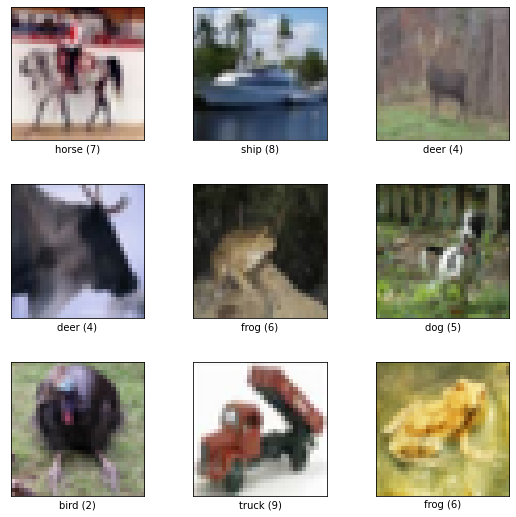

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

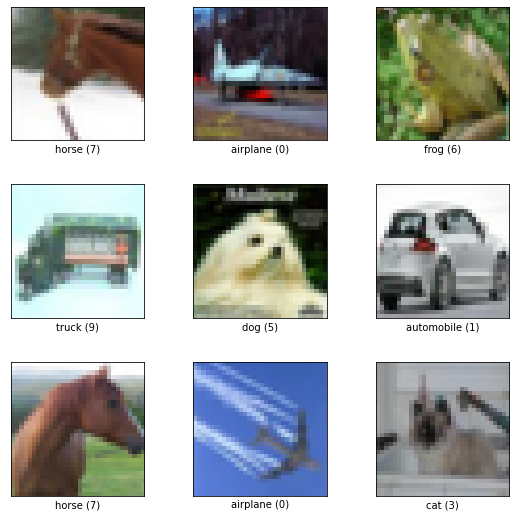

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

### 5. ResNet 만들기

#### 5_1 ResNet_34 만들기

In [11]:
def resnet_34(input_shape):
    input_tensor = keras.Input(shape = input_shape, dtype = "float32", name = "input")
    
    
    def conv1_layer(x):
        x = keras.layers.ZeroPadding2D(padding = (3, 3))(x)
        x = keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.ZeroPadding2D(padding = (1,1))(x)
        
        return x
    
    
    def conv2_layer(x):         
        x = keras.layers.MaxPooling2D(pool_size = (3, 3), strides = 2)(x)
        
        shortcut = x
        
        for i in range(3):
            if (i == 0):
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x        = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                shortcut = keras.layers.Conv2D(filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = "same")(shortcut)            
                x        = keras.layers.BatchNormalization()(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation("relu")(x)
                
                shortcut = x
                
            else:
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)            
 
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation("relu")(x)  
 
                shortcut = x
        return x
    
    
    def conv3_layer(x):        
        shortcut = x
        
        for i in range(4):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
                
                x        = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "valid")(x)
                shortcut = keras.layers.Conv2D(filters = 128, kernel_size = (1, 1), strides = (2, 2), padding = "same")(shortcut)
                x        = keras.layers.BatchNormalization()(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)            
                
                x = keras.layers.Add()([x, shortcut])    
                x = keras.layers.Activation("relu")(x)    
                
                shortcut = x
                
            else:
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)            
                
                x = keras.layers.Add()([x, shortcut])     
                x = keras.layers.Activation("relu")(x)
 
                shortcut = x      
            
        return x
    
    
    def conv4_layer(x):
        shortcut = x
        
        for i in range(6):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
 
                x        = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                shortcut = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (2, 2), padding = "same")(shortcut)
                x        = keras.layers.BatchNormalization()(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)
 
                x = keras.layers.Add()([x, shortcut]) 
                x = keras.layers.Activation("relu")(x)
  
                shortcut = x
            
            else:
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)            
 
                x = keras.layers.Add()([x, shortcut])    
                x = keras.layers.Activation("relu")(x)
 
                shortcut = x
        
        return x
    
    
    def conv5_layer(x):
        shortcut = x
        
        for i in range(3):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
 
                x        = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                shortcut = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (2, 2), padding = "same")(shortcut)
                x        = keras.layers.BatchNormalization()(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)            
 
                x = keras.layers.Add()([x, shortcut])  
                x = keras.layers.Activation("relu")(x)      
 
                shortcut = x
    
            else:
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)           
            
                x = keras.layers.Add()([x, shortcut]) 
                x = keras.layers.Activation("relu")(x)       
 
                shortcut = x
    
        return x
    
    x = conv1_layer(input_tensor)
    x = conv2_layer(x)
    x = conv3_layer(x)
    x = conv4_layer(x)
    x = conv5_layer(x)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    output_tensor = keras.layers.Dense(10, activation = "softmax")(x)
    
    return keras.models.Model(input_tensor, output_tensor)

#### 5_2 ResNet_50 만들기

In [12]:
def resnet_50(input_shape):
    input_tensor = keras.Input(shape = input_shape, dtype = "float32", name = "input")
    
    
    def conv1_layer(x):
        x = keras.layers.ZeroPadding2D(padding = (3, 3))(x)
        x = keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.ZeroPadding2D(padding = (1,1))(x)
        
        return x
    
    
    def conv2_layer(x):         
        x = keras.layers.MaxPooling2D(pool_size = (3, 3), strides = 2)(x)
        
        shortcut = x
        
        for i in range(3):
            if (i == 0):
                x = keras.layers.Conv2D(filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x        = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                shortcut = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(shortcut)            
                x        = keras.layers.BatchNormalization()(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation("relu")(x)
                
                shortcut = x
                
            else:
                x = keras.layers.Conv2D(filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)            
 
                x = keras.layers.Add()([x, shortcut])   
                x = keras.layers.Activation("relu")(x)  
 
                shortcut = x
        return x
    
    
    def conv3_layer(x):        
        shortcut = x
        
        for i in range(4):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 128, kernel_size = (1, 1), strides = (2, 2), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)        
                
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
                
                x        = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                shortcut = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (2, 2), padding = "valid")(shortcut)
                x        = keras.layers.BatchNormalization()(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)            
                
                x = keras.layers.Add()([x, shortcut])    
                x = keras.layers.Activation("relu")(x)    
                
                shortcut = x
                
            else:
                x = keras.layers.Conv2D(filters = 128, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)            
                
                x = keras.layers.Add()([x, shortcut])     
                x = keras.layers.Activation("relu")(x)
 
                shortcut = x      
            
        return x
    
    
    def conv4_layer(x):
        shortcut = x
        
        for i in range(6):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (2, 2), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)        
            
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
 
                x        = keras.layers.Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                shortcut = keras.layers.Conv2D(filters = 1024, kernel_size = (1, 1), strides = (2, 2), padding = "valid")(shortcut)
                x        = keras.layers.BatchNormalization()(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)
 
                x = keras.layers.Add()([x, shortcut]) 
                x = keras.layers.Activation("relu")(x)
  
                shortcut = x
            
            else:
                x = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)            
 
                x = keras.layers.Add()([x, shortcut])    
                x = keras.layers.Activation("relu")(x)
 
                shortcut = x
        
        return x
    
    
    def conv5_layer(x):
        shortcut = x
        
        for i in range(3):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (2, 2), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)        
            
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
 
                x        = keras.layers.Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                shortcut = keras.layers.Conv2D(filters = 2048, kernel_size = (1, 1), strides = (2, 2), padding = "valid")(shortcut)
                x        = keras.layers.BatchNormalization()(x)
                shortcut = keras.layers.BatchNormalization()(shortcut)            
 
                x = keras.layers.Add()([x, shortcut])  
                x = keras.layers.Activation("relu")(x)      
 
                shortcut = x
    
            else:
                x = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)           
            
                x = keras.layers.Add()([x, shortcut]) 
                x = keras.layers.Activation("relu")(x)       
 
                shortcut = x
    
        return x
    
    x = conv1_layer(input_tensor)
    x = conv2_layer(x)
    x = conv3_layer(x)
    x = conv4_layer(x)
    x = conv5_layer(x)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    output_tensor = keras.layers.Dense(10, activation="softmax")(x)
    
    return keras.models.Model(input_tensor, output_tensor)

#### 5_3. build_resnet

In [13]:
def build_resnet(input_shape = (32, 32, 3), is_50 = True):
    if is_50:
        model = resnet_50(input_shape)
    else:
        model = resnet_34(input_shape)
        
    return model

In [14]:
resnet_34 = build_resnet(input_shape = (32, 32, 3), is_50 = False)

In [15]:
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
resnet_50 = build_resnet(input_shape = (32, 32, 3), is_50 = True)

In [17]:
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 16, 16, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 16, 16, 64)   256         conv2d_37[0][0]                  
____________________________________________________________________________________________

### 6. plain network 만들기

#### 6_1. plain_34 만들기

In [18]:
def plain_34(input_shape):
    input_tensor = keras.Input(shape = input_shape, dtype = "float32", name = "input")
    
    
    def conv1_layer(x):
        x = keras.layers.ZeroPadding2D(padding = (3, 3))(x)
        x = keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.ZeroPadding2D(padding = (1,1))(x)
        
        return x
    
    
    def conv2_layer(x):         
        x = keras.layers.MaxPooling2D(pool_size = (3, 3), strides = 2)(x)
        
        for i in range(3):
            if (i == 0):
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
            else:
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
        
        return x
    
    
    def conv3_layer(x):
        for i in range(4):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
                
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)    
                
            else:
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)            
                x = keras.layers.Activation("relu")(x)
            
        return x
    
    
    def conv4_layer(x):
        for i in range(6):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
 
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            
            else:
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)            
                x = keras.layers.Activation("relu")(x)

        return x
    
    
    def conv5_layer(x):
        for i in range(3):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
 
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)      
 
            else:
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)           
                x = keras.layers.Activation("relu")(x)       
 
        return x
    
    x = conv1_layer(input_tensor)
    x = conv2_layer(x)
    x = conv3_layer(x)
    x = conv4_layer(x)
    x = conv5_layer(x)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    output_tensor = keras.layers.Dense(10, activation = "softmax")(x)
    
    return keras.models.Model(input_tensor, output_tensor)

#### 6_2. plain_50 만들기

In [19]:
def plain_50(input_shape):
    input_tensor = keras.Input(shape = input_shape, dtype = "float32", name = "input")
    
    
    def conv1_layer(x):
        x = keras.layers.ZeroPadding2D(padding = (3, 3))(x)
        x = keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.ZeroPadding2D(padding = (1,1))(x)
        
        return x
    
    
    def conv2_layer(x):         
        x = keras.layers.MaxPooling2D(pool_size = (3, 3), strides = 2)(x)
        
        for i in range(3):
            if (i == 0):
                x = keras.layers.Conv2D(filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
            else:
                x = keras.layers.Conv2D(filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            
                x = keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)            
                x = keras.layers.Activation("relu")(x)
            
        return x
    
    
    def conv3_layer(x):
        for i in range(4):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 128, kernel_size = (1, 1), strides = (2, 2), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)        
                
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
                
                x = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)    
                
            else:
                x = keras.layers.Conv2D(filters = 128, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
                
                x = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)            
                x = keras.layers.Activation("relu")(x)
 
        return x
    
    
    def conv4_layer(x):   
        for i in range(6):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (2, 2), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)        
            
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
 
                x = keras.layers.Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)

            else:
                x = keras.layers.Conv2D(filters = 256, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            
                x = keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)            
                x = keras.layers.Activation("relu")(x)
        
        return x
    
    
    def conv5_layer(x):
        for i in range(3):
            if(i == 0):
                x = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (2, 2), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)        
            
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)  
 
                x = keras.layers.Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)      

            else:
                x = keras.layers.Conv2D(filters = 512, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            
                x = keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = "same")(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
 
                x = keras.layers.Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1, 1), padding = "valid")(x)
                x = keras.layers.BatchNormalization()(x)           
                x = keras.layers.Activation("relu")(x)       
 
        return x
    
    x = conv1_layer(input_tensor)
    x = conv2_layer(x)
    x = conv3_layer(x)
    x = conv4_layer(x)
    x = conv5_layer(x)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    output_tensor = keras.layers.Dense(10, activation="softmax")(x)
    
    return keras.models.Model(input_tensor, output_tensor)

#### 6_3. build_plain

In [20]:
def build_plain(input_shape = (32, 32, 3), is_50 = True):
    if is_50:
        model = plain_50(input_shape)
    else:
        model = plain_34(input_shape)
        
    return model

In [21]:
plain_34 = build_plain(input_shape = (32, 32, 3), is_50 = False)
plain_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 38, 38, 3)         0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_90 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 18, 18, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0   

In [22]:
plain_50 = build_plain(input_shape = (32, 32, 3), is_50 = True)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 38, 38, 3)         0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_123 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_115 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 18, 18, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0   

### 7. ResNet VS Plain

In [23]:
BATCH_SIZE = 256
EPOCH      = 40

In [24]:
(ds_train, ds_test), ds_info = tfds.load("cifar10", 
                                         split         = ['train', 'test'], 
                                         as_supervised = True, 
                                         shuffle_files = True,
                                         with_info     = True)

ds_train = apply_normalize_on_dataset(ds_train, batch_size = BATCH_SIZE)
ds_test  = apply_normalize_on_dataset(ds_test,  batch_size = BATCH_SIZE)

In [25]:
resnet_34.compile(loss      = "sparse_categorical_crossentropy",
                  optimizer = tf.keras.optimizers.SGD(lr = 0.01, clipnorm = 1.),
                  metrics   = ["accuracy"])

history_resnet_34 = resnet_34.fit(ds_train,
                                  steps_per_epoch     = int(ds_info.splits["train"].num_examples / BATCH_SIZE),
                                  validation_steps    = int(ds_info.splits["test"].num_examples  / BATCH_SIZE),
                                  epochs              = EPOCH,
                                  validation_data     = ds_test,
                                  verbose             = 1,
                                  use_multiprocessing = True)

Epoch 1/40
195/195 [==============================] - 58s 167ms/step - loss: 2.3054 - accuracy: 0.2228 - val_loss: 2.5023 - val_accuracy: 0.1045
Epoch 2/40
195/195 [==============================] - 21s 107ms/step - loss: 1.6546 - accuracy: 0.3987 - val_loss: 2.5609 - val_accuracy: 0.1722
Epoch 3/40
195/195 [==============================] - 13s 68ms/step - loss: 1.4439 - accuracy: 0.4779 - val_loss: 1.7998 - val_accuracy: 0.3569
Epoch 4/40
195/195 [==============================] - 13s 68ms/step - loss: 1.2696 - accuracy: 0.5461 - val_loss: 1.5712 - val_accuracy: 0.4467
Epoch 5/40
195/195 [==============================] - 13s 68ms/step - loss: 1.0818 - accuracy: 0.6187 - val_loss: 1.5162 - val_accuracy: 0.4747
Epoch 6/40
195/195 [==============================] - 13s 69ms/step - loss: 0.9017 - accuracy: 0.6926 - val_loss: 1.5795 - val_accuracy: 0.4788
Epoch 7/40
195/195 [==============================] - 13s 69ms/step - loss: 0.7162 - accuracy: 0.7622 - val_loss: 1.6616 - val_accurac

In [26]:
resnet_50.compile(loss      = "sparse_categorical_crossentropy",
                  optimizer = tf.keras.optimizers.SGD(lr = 0.01, clipnorm = 1.),
                  metrics   = ["accuracy"])

history_resnet_50 = resnet_50.fit(ds_train,
                                  steps_per_epoch     = int(ds_info.splits["train"].num_examples / BATCH_SIZE),
                                  validation_steps    = int(ds_info.splits["test"].num_examples  / BATCH_SIZE),
                                  epochs              = EPOCH,
                                  validation_data     = ds_test,
                                  verbose             = 1,
                                  use_multiprocessing = True)

Epoch 1/40
195/195 [==============================] - 61s 180ms/step - loss: 3.0090 - accuracy: 0.1215 - val_loss: 2.4730 - val_accuracy: 0.1017
Epoch 2/40
195/195 [==============================] - 23s 119ms/step - loss: 2.4920 - accuracy: 0.1670 - val_loss: 2.6476 - val_accuracy: 0.1086
Epoch 3/40
195/195 [==============================] - 16s 84ms/step - loss: 2.2858 - accuracy: 0.2051 - val_loss: 2.2851 - val_accuracy: 0.1956
Epoch 4/40
195/195 [==============================] - 16s 84ms/step - loss: 2.1294 - accuracy: 0.2482 - val_loss: 2.2199 - val_accuracy: 0.2474
Epoch 5/40
195/195 [==============================] - 16s 84ms/step - loss: 2.0586 - accuracy: 0.2677 - val_loss: 2.2197 - val_accuracy: 0.2614
Epoch 6/40
195/195 [==============================] - 16s 84ms/step - loss: 1.9359 - accuracy: 0.3060 - val_loss: 2.2682 - val_accuracy: 0.2687
Epoch 7/40
195/195 [==============================] - 16s 84ms/step - loss: 1.8014 - accuracy: 0.3567 - val_loss: 2.2297 - val_accurac

In [27]:
plain_34.compile(loss      = "sparse_categorical_crossentropy",
                  optimizer = tf.keras.optimizers.SGD(lr = 0.01, clipnorm = 1.),
                  metrics   = ["accuracy"])

history_plain_34 = plain_34.fit(ds_train,
                                steps_per_epoch     = int(ds_info.splits["train"].num_examples / BATCH_SIZE),
                                validation_steps    = int(ds_info.splits["test"].num_examples  / BATCH_SIZE),
                                epochs              = EPOCH,
                                validation_data     = ds_test,
                                verbose             = 1,
                                use_multiprocessing = True)

Epoch 1/40
195/195 [==============================] - 18s 66ms/step - loss: 2.3191 - accuracy: 0.1258 - val_loss: 2.3469 - val_accuracy: 0.1041
Epoch 2/40
195/195 [==============================] - 13s 64ms/step - loss: 2.1857 - accuracy: 0.1771 - val_loss: 2.7505 - val_accuracy: 0.1020
Epoch 3/40
195/195 [==============================] - 13s 64ms/step - loss: 1.9999 - accuracy: 0.2428 - val_loss: 2.1807 - val_accuracy: 0.2100
Epoch 4/40
195/195 [==============================] - 12s 64ms/step - loss: 1.8315 - accuracy: 0.3060 - val_loss: 1.8553 - val_accuracy: 0.3190
Epoch 5/40
195/195 [==============================] - 13s 64ms/step - loss: 1.7235 - accuracy: 0.3578 - val_loss: 1.7396 - val_accuracy: 0.3513
Epoch 6/40
195/195 [==============================] - 13s 65ms/step - loss: 1.6008 - accuracy: 0.4102 - val_loss: 1.6597 - val_accuracy: 0.3836
Epoch 7/40
195/195 [==============================] - 13s 65ms/step - loss: 1.5117 - accuracy: 0.4420 - val_loss: 1.5598 - val_accuracy:

In [28]:
plain_50.compile(loss      = "sparse_categorical_crossentropy",
                  optimizer = tf.keras.optimizers.SGD(lr = 0.01, clipnorm = 1.),
                  metrics   = ["accuracy"])

history_plain_50 = plain_50.fit(ds_train,
                                steps_per_epoch     = int(ds_info.splits["train"].num_examples / BATCH_SIZE),
                                validation_steps    = int(ds_info.splits["test"].num_examples  / BATCH_SIZE),
                                epochs              = EPOCH,
                                validation_data     = ds_test,
                                verbose             = 1,
                                use_multiprocessing = True)

Epoch 1/40
195/195 [==============================] - 20s 68ms/step - loss: 2.4772 - accuracy: 0.1082 - val_loss: 2.3203 - val_accuracy: 0.1006
Epoch 2/40
195/195 [==============================] - 13s 65ms/step - loss: 2.3876 - accuracy: 0.1085 - val_loss: 2.3548 - val_accuracy: 0.0983
Epoch 3/40
195/195 [==============================] - 13s 65ms/step - loss: 2.3472 - accuracy: 0.1153 - val_loss: 2.3347 - val_accuracy: 0.1056
Epoch 4/40
195/195 [==============================] - 13s 65ms/step - loss: 2.3345 - accuracy: 0.1140 - val_loss: 2.5999 - val_accuracy: 0.1381
Epoch 5/40
195/195 [==============================] - 13s 65ms/step - loss: 2.3128 - accuracy: 0.1248 - val_loss: 2.9617 - val_accuracy: 0.1329
Epoch 6/40
195/195 [==============================] - 13s 65ms/step - loss: 2.2873 - accuracy: 0.1322 - val_loss: 3.1207 - val_accuracy: 0.1357
Epoch 7/40
195/195 [==============================] - 13s 65ms/step - loss: 2.2801 - accuracy: 0.1377 - val_loss: 2.8332 - val_accuracy:

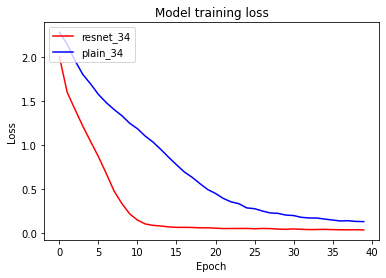

In [29]:
plt.plot(history_resnet_34.history["loss"], "r")
plt.plot(history_plain_34.history["loss"], "b")
plt.title("Model training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["resnet_34", "plain_34"], loc = "upper left")
plt.show()

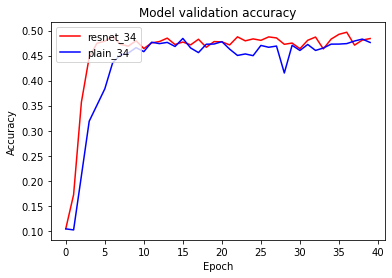

In [30]:
plt.plot(history_resnet_34.history["val_accuracy"], "r")
plt.plot(history_plain_34.history["val_accuracy"], "b")
plt.title("Model validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["resnet_34", "plain_34"], loc = "upper left")
plt.show()

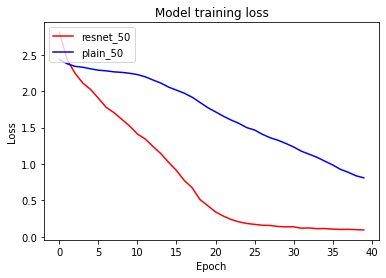

In [31]:
plt.plot(history_resnet_50.history["loss"], "r")
plt.plot(history_plain_50.history["loss"], "b")
plt.title("Model training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["resnet_50", "plain_50"], loc = "upper left")
plt.show()

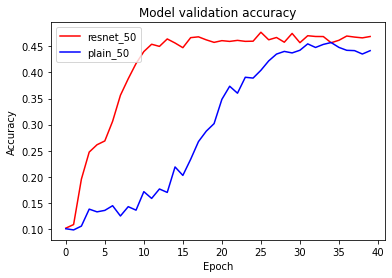

In [32]:
plt.plot(history_resnet_50.history["val_accuracy"], "r")
plt.plot(history_plain_50.history["val_accuracy"], "b")
plt.title("Model validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["resnet_50", "plain_50"], loc = "upper left")
plt.show()

### 8. 회고록

In [ ]:
# 처음에 ResNet을 어떻게 블록으로 단순화하여 구현할지 생각하다가 시간이 금방 지나갔다.
# 뛰어넘어서 합치는 것과 처음 레이어에서는 / 2를 해서 dim을 줄이는것이 너무 어려웠다.
# 결국 레이어마다 함수를 만들어서 하는 식으로 했다.
# 블록보다는 노가다식으로 구현을 했다.
# 그리고 비교하는 모델에는 뛰어넘어서 합쳐지는 부분만 제거하여 만들었다.
# 그리고 40번 학습을 시킨 후 학습률의 차이를 각각 시각화 해보았다.
# 실험 결과 ResNet이 Plain보다 훨씬 빠르게 안정적으로 수렴하는 것을 볼 수 있다.